In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

# Visualize the Data

In [17]:
df = pd.read_csv("./data/features.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Return,Open-Close,Open-Low,Open-High,Close-MA 20D,RSI 14D,Normalized Volume,Realized Volatility 30D,VIX,VIX Move,VIX Open-Close
0,1995-01-03,-0.000348,-0.000218,-0.004377,0.000131,0.007283,0.532690,-0.556965,0.100032,14.25,0.079545,0.011356
1,1995-01-04,0.003485,0.003441,-0.003420,0.003463,0.009975,0.563792,0.273094,0.099786,13.53,-0.050526,-0.024513
2,1995-01-05,-0.000803,-0.000847,-0.002127,0.001237,0.008364,0.554631,0.115542,0.097703,13.50,-0.002217,-0.014599
3,1995-01-06,0.000739,0.000652,-0.001977,0.004583,0.008066,0.561685,0.143239,0.081286,13.13,-0.027407,-0.039503
4,1995-01-09,0.000326,0.000347,-0.002019,0.002388,0.006700,0.564956,-0.229424,0.081226,13.33,0.015232,-0.014782


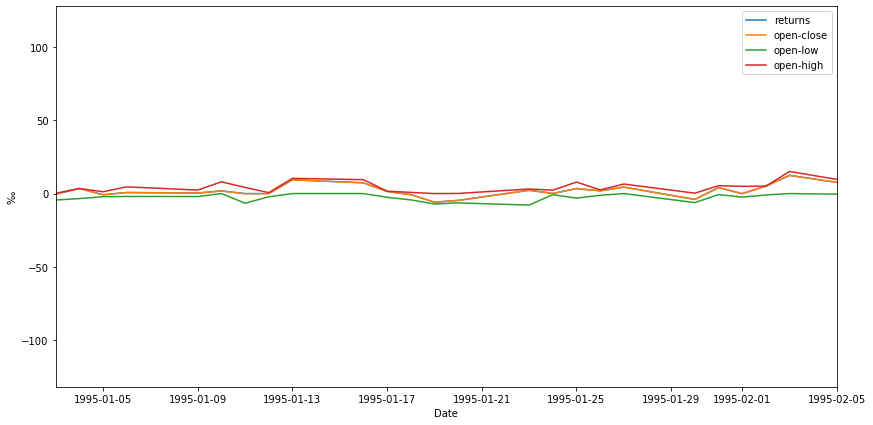

In [18]:
fix, ax = plt.subplots(figsize=(14,7))

ax.plot(df['Date'], df['Return']*1000, label = 'returns')
ax.plot(df['Date'], df['Open-Close']*1000, label = 'open-close')
ax.plot(df['Date'], df['Open-Low']*1000, label = 'open-low')
ax.plot(df['Date'], df['Open-High']*1000, label = 'open-high')

ax.set_xlabel('Date')
ax.set_ylabel('‰')
plt.xlim(pd.to_datetime('1995-01-03'), pd.to_datetime('1995-02-05'))
plt.legend()
plt.show()

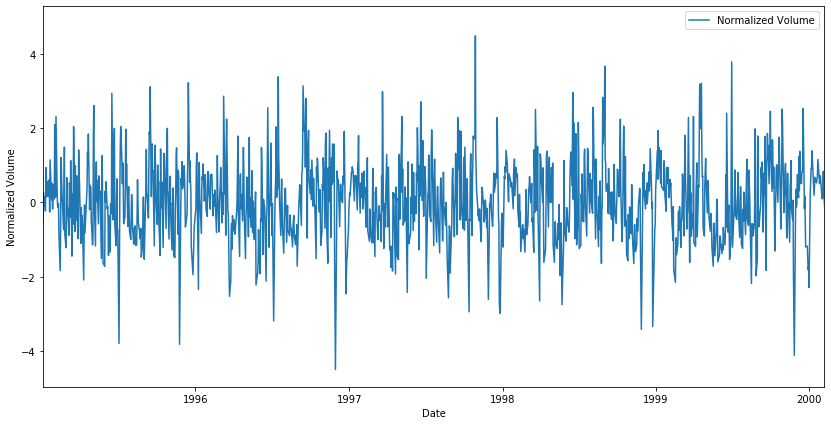

In [19]:
fix, ax = plt.subplots(figsize=(14,7))

ax.plot(df['Date'], df['Normalized Volume'], label = 'Normalized Volume')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Volume')
plt.xlim(pd.to_datetime('1995-01-03'), pd.to_datetime('2000-02-05'))
plt.legend()
plt.show()

# MLP GAN

In [78]:
def prep_data(data: np.array, window_len, scaler) -> np.array:
    
    """
    Args:
      -  data = np.array
      -  window_len = length of window
      -  scaler = sklearn.preprocessing

    Returns:
      - processed: preprocessed data as python list
    """
    # normalize data
    scaler = scaler.fit(data)
    scaled_data = scaler.transform(data)
    
    # group data into windows of length window_len
    windows = []
    for i in range(len(data) - window_len):
        windows.append(scaled_data[i:i+window_len])
        
    # reorder the data
    idx = np.random.permutation(len(windows))

    processed = []
    for i in range(len(windows)):
        processed.append(windows[idx[i]])
    
    return processed


Very simple GAN implementation for our baseline. Will use convolutions and TimeGAN as the next models

In [144]:
class Generator(torch.nn.Module):

    def __init__(self, input_length: int):
        super(Generator, self).__init__()
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

In [145]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(input_length), 1);
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense(x))

In [162]:
def train_gan(true_data, training_steps,lr = 0.001):
    
    # Models
    generator = Generator(true_data.shape[1])
    discriminator = Discriminator(true_data.shape[1])

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr = lr)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

    # binary cross entropy loss
    loss = nn.BCELoss()

    for i in range(training_steps):
        
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        # Create noisy input for generator
        # if minmaxscaling was used, the inputs should be bertween 0 and 1
        noise = torch.rand(true_data.shape[0], true_data.shape[1])
        
        generated_data = generator(noise)

        # convert real data to torch
        true_labels = torch.tensor(np.ones((len(true_data),1))).float()
        true_data = torch.tensor(true_data).float()
        # Train the generator
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        generator_discriminator_out = discriminator(generated_data)
        generator_loss = loss(generator_discriminator_out, true_labels)
        generator_loss.backward()
        generator_optimizer.step()

        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)        
        true_discriminator_loss = loss(true_discriminator_out, true_labels)

        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros((len(true_data),1)))
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        if i%50==0:
            print("epoch: ", i, "discriminator loss: ",  discriminator_loss.item())
    return generator, discriminator
        

In [178]:
# define minmax scaler
scaler = MinMaxScaler()

# set index to date
try:
    df = df.set_index('Date').sort_index()
except:
    df = df

# prep data
df = df.drop(['Close-MA 20D', 'RSI 14D','Realized Volatility 30D','VIX Move'], axis=1)
data = prep_data(df.values, 30, scaler)

# check size
print(len(data), data[0].shape)
data = np.array(data)
reshaped_data =  data.reshape(len(data),data.shape[1]*data.shape[2])

print(data.shape)

6769 (30, 7)
(6769, 30, 7)


In [179]:
gen, disc = train_gan(reshaped_data, 1000,0.005)

epoch:  0 discriminator loss:  0.7040930986404419


/opt/anaconda3/envs/finance4/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:  50 discriminator loss:  0.3663259744644165
epoch:  100 discriminator loss:  0.3105637729167938
epoch:  150 discriminator loss:  0.1117689311504364
epoch:  200 discriminator loss:  0.041141510009765625
epoch:  250 discriminator loss:  0.038180503994226456
epoch:  300 discriminator loss:  0.021005654707551003
epoch:  350 discriminator loss:  0.010128200054168701
epoch:  400 discriminator loss:  0.00657725241035223
epoch:  450 discriminator loss:  0.007054236717522144
epoch:  500 discriminator loss:  0.004607973154634237
epoch:  550 discriminator loss:  0.004756499081850052
epoch:  600 discriminator loss:  0.005274567287415266
epoch:  650 discriminator loss:  0.005587965250015259
epoch:  700 discriminator loss:  0.0040128519758582115
epoch:  750 discriminator loss:  0.0032560271210968494
epoch:  800 discriminator loss:  0.0027261346112936735
epoch:  850 discriminator loss:  0.002421922516077757
epoch:  900 discriminator loss:  0.002166805323213339
epoch:  950 discriminator loss:  

In [182]:
noise = torch.rand(reshaped_data.shape[0], reshaped_data.shape[1])
generated_data = gen(noise)
generated_data = generated_data.reshape(data.shape[0],data.shape[1],data.shape[2])

In [183]:
generated_data.shape

torch.Size([6769, 30, 7])

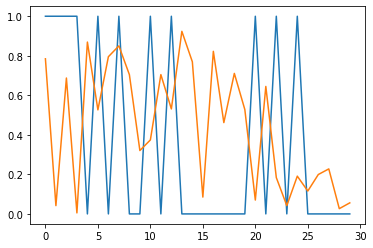

In [202]:
plt.plot(generated_data[0,:,0].detach().numpy(),label='generated data')
noise_0 = noise[0].reshape(30,7)[:,0]
plt.plot(noise_1,label = 'noise')
plt.show()

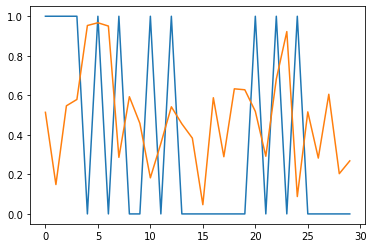

In [203]:
plt.plot(generated_data[1,:,0].detach().numpy(),label='generated data')
noise_1 = noise[0].reshape(30,7)[:,1]
plt.plot(noise_1,label = 'noise')
plt.show()

# TimeGAN

In [22]:
# define minmax scaler
scaler = MinMaxScaler()

# set index to date
try:
    df = df.set_index('Date').sort_index()
except:
    df = df

# prep data
data = prep_data(df.values, 30, scaler)

# check size
print(len(data), data[0].shape)

6769 (30, 11)


In [23]:
seq_len = 30        # Timesteps
n_seq = 11          # Features

hidden_dim = 24     # Hidden units for generator (GRU & LSTM)

gamma = 1           # discriminator loss

noise_dim = 32      # Used by generator as a starter dimension
dim = 128           # UNUSED
batch_size = 128

learning_rate = 5e-4
beta_1 = 0          # UNUSED
beta_2 = 1          # UNUSED
data_dim = 28       # UNUSED

# batch_size, lr, beta_1, beta_2, noise_dim, data_dim, layers_dim
gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, data_dim, dim]

In [24]:
from ydata_synthetic.synthesizers.timeseries import TimeGAN
# define model
synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
synth.train(energy_data, train_steps=500)
synth.save('synth.pkl')

synth_data = synth.sample(len(data))

ModuleNotFoundError: No module named 'ydata_synthetic'

In [ ]:
synth_data = np.array(synth_data)

import pickle as pkl
with open('generated.pkl','wb') as f:
    pkl.dump(synth_data, f)


# LSTM Prediction

Eventually, we might want to preprocess the data (detrend and such). For now, I am implementing a a simple binary forecasting method. I plotted the data above and I don't see much of a trend in the data, since we model returns anyway, but it might be best practice to subtract the running mean or perform similar kind of preprocessing/feature transformation. Also, I'm going to add code to do proper cross validation for time series (sliding window approach). For now I have only implemented a basic train/test split, which I think should be fine for the midterm report. The main focus should be on the data generation, not the forecasting. also only using return to predict the next day's returns for now, i tried with all features, and it wasn't any better.

In [51]:
def train_test_window(data, window_len, split):    
    """
    Passes sliding window of window_len, and splits into train/test
    
    Args:
      -  data = np.array
      -  window_len = length of window
      -  split = training fraction (e.g 0.8)

    """
    # get train size
    train_set_size = int(np.round(split*len(data)))
    
    # sliding window
    windows = []
    for i in range(len(data) - window_len):
        windows.append(data[i:i+window_len])
         
    #get train/test split
    data = np.array(windows)
    train_size = int(np.round(split*len(data)))

    x_train = data[:train_set_size,:-1,:]
    y_train = np.expand_dims(data[:train_set_size,-1,0],1)
    
    x_test = data[train_set_size:,:-1]
    y_test = np.expand_dims(data[train_set_size:,-1,0],1)

    return x_train, y_train, x_test, y_test
    

In [59]:
df = pd.read_csv("./data/features.csv")
df['Date'] = pd.to_datetime(df['Date'])

try:
    df = df.set_index('Date').sort_index()
except:
    df = df
    
scaler = MinMaxScaler()


returns = df[['Return']]
scaler.fit(returns)
scaled = scaler.transform(returns)
x_train, y_train, x_test, y_test = train_test_window(scaled, 60,0.9)

#scaler.fit(df.values)
#scaled = scaler.transform(df.values)
#x_train, y_train, x_test, y_test = train_test_window(scaled, 60,0.9)

In [60]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(6119, 59, 1) (6119, 1) (620, 59, 1) (620, 1)


In [61]:
import torch
import torchvision

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [62]:
from torch import nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [63]:
input_dim = x_train.shape[2]
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [64]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [65]:
losses = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    if t%10==0:
        print("Epoch ", t, "MSE: ", loss.item())
    if t==num_epochs-1:
        last = y_train_pred
    losses[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MSE:  0.43788743019104004
Epoch  10 MSE:  0.03924856707453728
Epoch  20 MSE:  0.011229720897972584
Epoch  30 MSE:  0.0046528480015695095
Epoch  40 MSE:  0.0026466134004294872
Epoch  50 MSE:  0.0024457413237541914
Epoch  60 MSE:  0.0024489175993949175
Epoch  70 MSE:  0.0024491159711033106
Epoch  80 MSE:  0.002445537829771638
Epoch  90 MSE:  0.002442833036184311


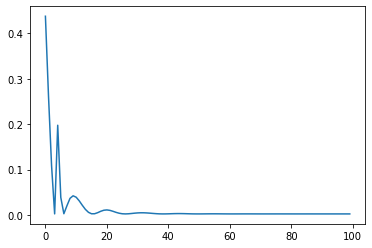

In [66]:
plt.plot(losses)

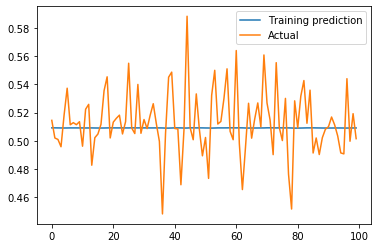

In [67]:
plt.plot(last.detach().numpy()[0:100],label = 'Training prediction')
plt.plot(y_train.numpy()[0:100],label = 'Actual')
plt.legend()
plt.show()

In [68]:
true = scaler.inverse_transform(y_train.numpy())
pred = scaler.inverse_transform(last.detach().numpy())

true = np.where(true>0,1,0)
pred = np.where(pred>0,1,0)

In [69]:
from sklearn.metrics import accuracy_score
print(accuracy_score(true,pred))

0.5370158522634417


# GRU Prediction

In [70]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


In [71]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [72]:
losses = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    if t%10==0:
        print("Epoch ", t, "MSE: ", loss.item())
    if t==num_epochs-1:
        last = y_train_pred
    losses[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MSE:  0.3651135265827179
Epoch  10 MSE:  0.01164175570011139
Epoch  20 MSE:  0.0037552225403487682
Epoch  30 MSE:  0.0037924377247691154
Epoch  40 MSE:  0.002683954080566764
Epoch  50 MSE:  0.002441319404169917
Epoch  60 MSE:  0.0024923307355493307
Epoch  70 MSE:  0.0024384427815675735
Epoch  80 MSE:  0.002437024610117078
Epoch  90 MSE:  0.0024322951212525368


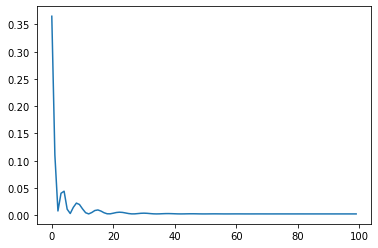

In [73]:
plt.plot(losses)

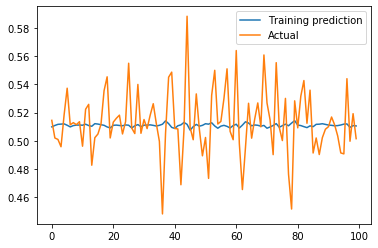

In [74]:
plt.plot(last.detach().numpy()[0:100],label = 'Training prediction')
plt.plot(y_train.numpy()[0:100],label = 'Actual')
plt.legend()
plt.show()

In [75]:
true = scaler.inverse_transform(y_train.numpy())
pred = scaler.inverse_transform(last.detach().numpy())

true = np.where(true>0,1,0)
pred = np.where(pred>0,1,0)

print(accuracy_score(true,pred))

0.5361987252819088
